## Mert Feature Extraction

In [3]:
from transformers import Wav2Vec2FeatureExtractor
from transformers import AutoModel
import torch
from torch import nn
import torchaudio.transforms as T
from omegaconf import OmegaConf
from tqdm import tqdm
import importlib
import numpy as np
import pickle 
def load_dataset(configs):
    # call dataset, build the set by config
    dataset = getattr(importlib.import_module('dataset'), f'{configs.name}')(**configs)
    return dataset

# loading our model weights
device = torch.device('cuda')
model = AutoModel.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True).to(device)
# loading the corresponding preprocessor config
processor = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-330M" ,trust_remote_code=True)
configs = OmegaConf.load('configs/MERT.yaml')
# load demo audio and set processor
configs.data['batch_size'] = 1
configs.data['name'] = 'GTZAN'

dataset = load_dataset(configs.data)
train_loader, valid_loader, test_loader = dataset.train_loader, dataset.valid_loader, dataset.test_loader
sampling_rate = 22050
outdir = '../data/MERT_extracted/'
resample_rate = processor.sampling_rate
# make sure the sample_rate aligned
for batch in tqdm(test_loader):
    input_values, attn_mask, label, fns = batch
    input_values, attn_mask, label = input_values.to(device), attn_mask.to(device), label.to(device)
    with torch.no_grad():
        # batch['inputs']['input_values'] = batch['inputs']['input_values'].squeeze(1)
        # outputs = model(**batch['inputs'], output_hidden_states=True)
        input_values = input_values.squeeze(1)
        outputs = model(input_values= input_values, attention_mask=attn_mask, output_hidden_states=True)
        outputs['last_hidden_state'] = outputs['last_hidden_state'].mean(-2).squeeze().detach().cpu().numpy()
        outputs['hidden_states'] = np.array([h.mean(-2).detach().cpu().numpy() for h in  outputs['hidden_states']])
        outputs['filename'] = fns[0].split('/')[-1]
        outputs['label'] = label.detach().cpu().numpy()
        
        with open(f"{outdir}/{outputs['filename'].strip('.wav')}.pkl", 'wb') as f:
            pickle.dump(dict(outputs), f)
        # torch.save(outputs, f"{outdir}/{outputs['filename'].strip('.wav')}.pkl")
 

Some weights of the model checkpoint at m-a-p/MERT-v1-330M were not used when initializing MERTModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing MERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MERTModel were not initialized from the model checkpoint at m-a-p/MERT-v1-330M and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: [Errno 2] No such file or directory: '../data/MERT_extracted/blues.00005.pkl'

In [11]:

from dataset import AudioDataset
import importlib
from transformers import AutoModel, Wav2Vec2FeatureExtractor
from omegaconf import OmegaConf
from tqdm import tqdm
import torch
import numpy as np
import pickle

def feature_extraction(outdir, adaption, adpt_layers, adpt_confs, indir=None, datasetClass=AudioDataset):


    def load_dataset(configs):
        # call dataset, build the set by config
        dataset = getattr(importlib.import_module('dataset'), f'{configs.name}')(**configs)
        return dataset

    device = torch.device('cuda:0')
    # Model should be selected through var, need update
    model = AutoModel.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)
    model = model.to(device)
    processor = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-330M" ,trust_remote_code=True)
    configs = OmegaConf.create(
        {
            'name': 'GTZAN',
            'batch_size': 1,
            'num_workers': 0,
            'root': indir,
            'datasetClass': 'StemsAudioDataset',
        }
    )
    dataset = load_dataset(configs)
    train_loader, valid_loader, test_loader = dataset.train_loader, dataset.valid_loader, dataset.test_loader
    # make sure the sample_rate aligned
    for loader in [train_loader, valid_loader, test_loader]:
        for batch in tqdm(loader):
            if isinstance(batch, list):
                input_values, attn_mask, label, fns = batch
                input_values, attn_mask, label = input_values.to(device), attn_mask.to(device), label.to(device)
            elif isinstance(batch, dict):
                attn_mask, label, fns =  batch['attention_mask'].to(device), batch['label'].to(device), batch['filename']
            with torch.no_grad():
                outputs = {}
                if not 'blues.00016' in fns[0]: continue
                print('bingo')
                for stem in ['vocals', 'bass', 'other', 'drums']:
                    input_values = batch[stem].squeeze(1).to(device)
                    output = model(input_values= input_values, attention_mask=attn_mask, output_hidden_states=True)
                    outputs[stem] = np.array([h.mean(-2).detach().cpu().numpy() for h in output['hidden_states']])
                outputs['filename'] = fns[0].split('/')[-1]
                outputs['label'] = label.detach().cpu().numpy()
                
                with open(f"{outdir}/{outputs['filename'].strip('.wav')}.pkl", 'wb') as f:
                    pickle.dump(dict(outputs), f)
    
    del model
    torch.cuda.empty_cache()

feature_extraction(
    outdir='/home/lego/Database/MERT_repr/original_4stems',
    indir='/home/lego/Database/separated_GTZAN',
    adaption=None,
    adpt_confs=None,
    adpt_layers=None,
)

Some weights of the model checkpoint at m-a-p/MERT-v1-330M were not used when initializing MERTModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing MERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MERTModel were not initialized from the model checkpoint at m-a-p/MERT-v1-330M and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bingo


100%|██████████| 250/250 [00:27<00:00,  9.24it/s]


In [2]:
import torch
torch.cuda.is_available()

/home/lego/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [6]:
fns

NameError: name 'fns' is not defined

In [1]:
import pickle
with open('/home/lego/Database/MERT_repr/original_4stems/blues.00016.pkl', 'rb') as f:
    d1 = pickle.load(f)
print(d1['drums'][-1,0])
with open('/home/lego/Database/MERT_repr/original_4stems/blues.00017.pkl', 'rb') as f:
    d2 = pickle.load(f)
print(d2['drums'][-1,0])

[-0.12460122  0.01689197  0.10805944 ... -0.07398413 -0.13836025
  0.05024229]
[-0.18001734  0.06645469  0.12552689 ...  0.05599949 -0.11724289
  0.09756288]


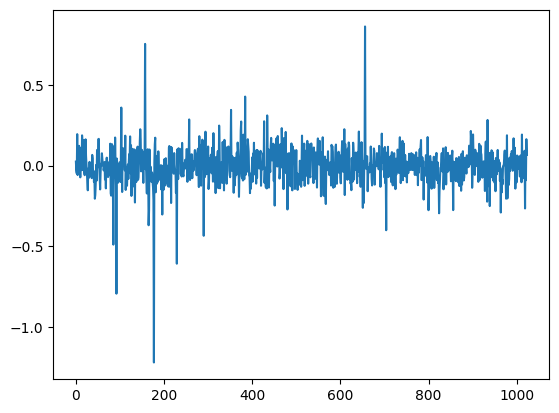

In [8]:
import matplotlib.pyplot as plt

plt.plot(d1['bass'][-1,0] - d2['drums'][-1,0])

In [15]:
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'